In [ ]:
!pip3 install numpy
!pip3 install matplotlib
!pip3 install pandas

!pip3 install opencv-python

!pip3 install tensorflow
!pip3 install keras
!pip3 install tensorflow

!pip3 install gTTS
!pip3 install librosa
!pip3 install pytesseract

In [1]:
# Utility Libraries
import os

# Image Processing and LinAlg libraries
import cv2
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# ML Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Open Source OCR
import pytesseract

# Text-to-Audio Libraries
from gtts import gTTS # for text-to-speech
# import soundfile as sf
from IPython.display import Audio
import librosa
import librosa.effects

In [13]:
# Setting seed for model
seed = 1234
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
# Make plots larger (default [6,4] on my machine)

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [12, 8]
# print(mpl.rcParams['figure.figsize'])

## Data Pre-Processing

In [3]:
# Data Directory

datadir = "data/samples/"

In [4]:
# Get images from data directory
num_images = len(os.listdir(datadir))
print(num_images)

1070


In [5]:
img_filenames = list()
for img_name in os.listdir(datadir):
  img_filenames.append(img_name)

captcha_labels_train = list()
for img_name in os.listdir(datadir):
  img_path = img_name.split(".")[0]
  captcha_labels_train.append(img_path)

### Removing Blur and Sharpening Images

##### Let's plot some images

Image shape: (50, 200, 3)


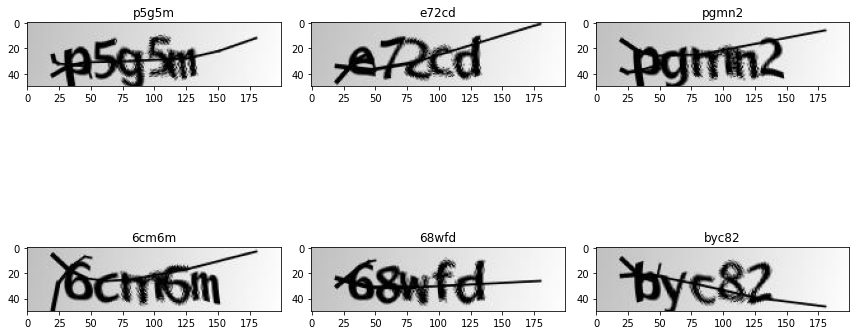

In [6]:
num_rows = 2
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols)

row = 0
for img_index in range(0, 6, 1):
    image = cv2.imread(datadir + img_filenames[img_index])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if img_index % 3 == 0 and img_index != 0:
        row += 1
    if (img_index == 1):
      print("Image shape:", image.shape)
    axes[row, img_index % num_cols].imshow(image)
    axes[row, img_index % num_cols].set_title(captcha_labels_train[img_index])

fig.tight_layout()
plt.show()

Let's find the number of jpg images in our dataset (it is mostly png)

In [7]:
jpg_count = 0
for name in img_filenames:
  if (".jpg" in name):
    jpg_count += 1
print(jpg_count)

30


In [8]:
img_fullpaths = [datadir + img_filename for img_filename in img_filenames]

In [10]:
img_label_lst = list(zip(img_fullpaths, captcha_labels_train))
img_label_df = pd.DataFrame(img_label_lst, columns=["img_path", "label"])
img_label_df.head()
# len(img_label_df)

,img_path,label
0,data/samples/p5g5m.png,p5g5m
1,data/samples/e72cd.png,e72cd
2,data/samples/pgmn2.png,pgmn2
3,data/samples/6cm6m.png,6cm6m
4,data/samples/68wfd.png,68wfd


##### Let us sharpen and denoised some images

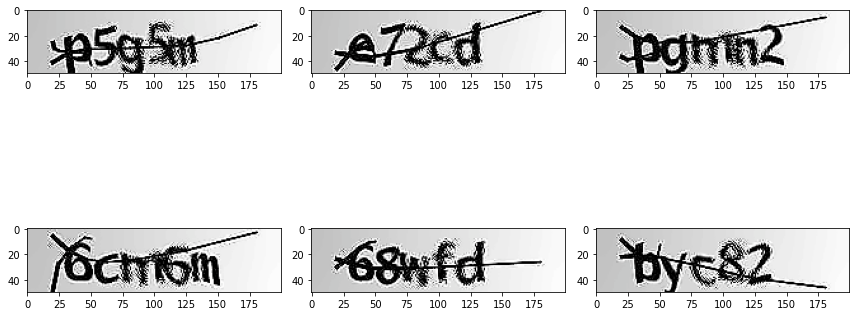

In [11]:
num_rows = 2
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols)

row = 0
for img_idx in range(0, 6, 1):
    img = cv2.imread(img_label_df['img_path'].values[img_idx])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # img = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21)

    sharpen_kernel = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])
    sharpened_image = cv2.filter2D(img, -1, sharpen_kernel)
    sharpened_image = cv2.fastNlMeansDenoisingColored(sharpened_image,None,10,10,7,21)

    if img_idx % 3 == 0 and img_idx != 0:
        row += 1
    axes[row, img_idx % num_cols].imshow(sharpened_image)
    # axes[row, img_idx % num_cols].set_title(captcha_labels_train[img_idx])

fig.tight_layout()
plt.show()

### Sharpen and denoise full dataset (Please run this cell once only)

In [ ]:
for img_idx in range(len(img_label_df)):
    path = img_label_df['img_path'].values[img_idx]
    img = cv2.imread(path)
    label = img_label_df['label'].values[img_idx]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # img = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21)

    # Sharpen kernel
    sharpen_kernel = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])
    sharpened_image = cv2.filter2D(img, -1, sharpen_kernel)

    # Denoising
    final_image = cv2.fastNlMeansDenoisingColored(sharpened_image,None,10,10,7,21)

    cv2.imwrite(path, final_image)

## Testing Pytesseract Open-Source OCR

In [12]:
tesseract_preds = list()

for img_idx in range(len(img_label_df)):
    path = img_label_df['img_path'].values[img_idx]
    img = cv2.imread(path)
    label = img_label_df['label'].values[img_idx]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    tesseract_preds.append(pytesseract.image_to_string(img_rgb))

tesseract_output = list(zip(captcha_labels_train, tesseract_preds))
tesseract_output = pd.DataFrame(tesseract_output, columns=["true_label", "tesseract_prediction"])


tesseract_output_demo = tesseract_output.sort_values(by='tesseract_prediction', ascending=False)
tesseract_output_demo.head()

,true_label,tesseract_prediction
42,excmn,xan —\n
463,ydd3g,wi\n
1035,cen55,wenss\n
50,cwgyx,cwayx\n
363,w4x2m,WwAx2mn\n


#### The output is subpar. Pytesseract fails to detect text in most CAPTCHA images. And it detects the wrong characters where it does detect text. As a consequence of these subpar results, we decided to implement another deep learning based OCR model.

## Convolutional Recurrent Neural Network Model

In [14]:
training_data = img_label_df.sample(frac=0.8)
val_data = img_label_df.drop(training_data.index)

print("Number of training samples: ", len(training_data))
print("Number of validation samples: ", len(val_data))

unique_chars = list()

for label in captcha_labels_train:
  for char in label:
    if char not in unique_chars:
      unique_chars.append(char)

unique_chars.sort()

char_to_int = dict()
int_to_char = dict()

for index, char in enumerate(unique_chars):
  char_to_int[char] = index
  int_to_char[index] = char


def store_data_as_np_arrays(dataframe: pd.DataFrame, image_height: int, image_width: int, resize: bool):
  num_images = len(dataframe)
  images_as_array = np.zeros((num_images, 50, 200))
  labels_as_list = ['a']*num_images

  counter = 0
  for index, row in dataframe.iterrows():
    img_path = row["img_path"]
    label = row["label"]

    if (datadir + "samples") != img_path:

      image = cv2.imread(img_path)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

      if resize:
        image = cv2.resize(image, (image_width, image_height))

      images_as_array[counter] = (image/255.0).astype(np.float32)
      labels_as_list[counter] = label

      counter += 1
    
  labels_as_list = np.array(labels_as_list)
  return images_as_array, labels_as_list



# Build training data
training_data, training_labels = store_data_as_np_arrays(training_data, image_height = 50, image_width = 200, resize = True)
print("Number of training images: ", training_data.shape)
print("Number of training labels: ", training_labels.shape)

# Build validation data
validation_data, validation_labels = store_data_as_np_arrays(val_data, image_height = 50, image_width = 200, resize = True)
print("Number of validation images: ", validation_data.shape)
print("Number of validation labels: ", validation_labels.shape)

Number of training samples:  856
Number of validation samples:  214
Number of training images:  (856, 50, 200)
Number of training labels:  (856,)
Number of validation images:  (214, 50, 200)
Number of validation labels:  (214,)


In [15]:
class CaptchaDataGenerator(keras.utils.Sequence):
    def __init__(self, data, labels, char_map, batch_size=16, img_width=200, img_height=50, downsample_factor=4, max_length=5, shuffle=True):
        self.data = data
        self.labels = labels
        self.char_map = char_map
        self.batch_size = batch_size
        self.img_width = img_width
        self.img_height = img_height
        self.downsample_factor = downsample_factor
        self.max_length = max_length
        self.shuffle = shuffle
        self.indices = np.arange(len(data))    
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))
    
    def __getitem__(self, idx):
        curr_batch_idx = self.indices[idx*self.batch_size:(idx+1)*self.batch_size] # batch indices
        
        batch_len = len(curr_batch_idx)
        
        # Prep batches
        batch_images = np.ones((batch_len, self.img_width, self.img_height, 1), dtype=np.float32)
        batch_labels = np.ones((batch_len, self.max_length), dtype=np.float32)
        input_length = np.ones((batch_len, 1), dtype=np.int64) * (self.img_width // self.downsample_factor - 2)
        label_length = np.zeros((batch_len, 1), dtype=np.int64)
        
        
        for j, idx in enumerate(curr_batch_idx):
            # Convert image to shape (200, 50, 1)
            img = self.data[idx].T
            img = np.expand_dims(img, axis=-1)
            
            text = self.labels[idx]
            label = [self.char_map[ch] for ch in text]
            batch_images[j] = img
            batch_labels[j] = label
            label_length[j] = len(text)

        batch_inputs = {
                'input_data': batch_images,
                'input_label': batch_labels,
                'input_length': input_length,
                'label_length': label_length,
                }
        return batch_inputs, np.zeros(batch_len).astype(np.float32)
        
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

In [17]:
# Model constants (passed by default)
batch_size = 16
img_width=200
img_height=50 
downsample_factor=4
max_length=5

# Training Data Generator
train_data_generator = CaptchaDataGenerator(data=training_data, labels=training_labels, char_map=char_to_int)

# Test Data Generator
valid_data_generator = CaptchaDataGenerator(data=validation_data, labels=validation_labels, char_map=char_to_int)

In [32]:
# Open Source OCR Model: https://www.kaggle.com/code/aakashnain/building-a-captcha-ocr-in-tf2-0/notebook

class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred, input_length, label_length):
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        return loss


def build_model():
    # Input layer
    input_img = layers.Input(shape=(img_width, img_height, 1), name='input_data', dtype='float32')
    labels = layers.Input(name='input_label', shape=[max_length], dtype='float32')
    input_length = layers.Input(name='input_length', shape=[1], dtype='int64')
    label_length = layers.Input(name='label_length', shape=[1], dtype='int64')
    
    # Convolutional 1
    x = layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same', name='Conv1')(input_img)
    x = layers.MaxPooling2D((2,2), name='pool1')(x)
    
    # Convolutional 2
    x = layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same', name='Conv2')(x)
    x = layers.MaxPooling2D((2,2), name='pool2')(x)

    new_shape = ((img_width // 4), (img_height // 4)*64)
    x = layers.Reshape(target_shape=new_shape, name='reshape')(x)
    x = layers.Dense(64, activation='relu', name='dense1')(x)
    x = layers.Dropout(0.2)(x)
    
    # RNN
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.2))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)
    
    # Predictions
    x = layers.Dense(len(unique_chars)+1,activation='softmax', name='dense2',kernel_initializer='he_normal')(x)
    
    # Calculate CTC
    output = CTCLayer(name='ctc_loss')(labels, x, input_length, label_length)
    
    # Define the model
    model = keras.models.Model(inputs=[input_img, labels, input_length, label_length], outputs=output, name='captcha_ocr')
    
    # Optimizer
    '''
    Note:
        Using the legacy Optimizer since the current optimizer runs slow on M1. TensorFlow throws the following warnings:
            WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.SGD` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.SGD`.
            WARNING:absl:There is a known slowdown when using v2.11+ Keras optimizers on M1/M2 Macs. Falling back to the legacy Keras optimizer, i.e., `tf.keras.optimizers.legacy.SGD`.
    '''
    sgd = keras.optimizers.legacy.SGD(learning_rate=0.002, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)
    
    # Compile the model and return 
    model.compile(optimizer=sgd)
    return model

In [33]:
model = build_model()
model.summary()

Model: "captcha_ocr"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_data (InputLayer)     [(None, 200, 50, 1)]         0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 200, 50, 32)          320       ['input_data[0][0]']          
                                                                                                  
 pool1 (MaxPooling2D)        (None, 100, 25, 32)          0         ['Conv1[0][0]']               
                                                                                                  
 Conv2 (Conv2D)              (None, 100, 25, 64)          18496     ['pool1[0][0]']               
                                                                                        

In [20]:
# Add early stopping
es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(train_data_generator, validation_data=valid_data_generator, epochs=50, callbacks=[es])

Epoch 1/50
54/54 [==============================] - 8s 103ms/step - loss: 21.2691 - val_loss: 16.4908
Epoch 2/50
54/54 [==============================] - 5s 97ms/step - loss: 16.3945 - val_loss: 16.3937
Epoch 3/50
54/54 [==============================] - 5s 95ms/step - loss: 16.3248 - val_loss: 16.1991
Epoch 4/50
54/54 [==============================] - 5s 100ms/step - loss: 16.2003 - val_loss: 16.0801
Epoch 5/50
54/54 [==============================] - 5s 97ms/step - loss: 16.1053 - val_loss: 16.0184
Epoch 6/50
54/54 [==============================] - 6s 105ms/step - loss: 16.0452 - val_loss: 15.9906
Epoch 7/50
54/54 [==============================] - 5s 93ms/step - loss: 16.0190 - val_loss: 15.9675
Epoch 8/50
54/54 [==============================] - 5s 98ms/step - loss: 16.0344 - val_loss: 15.9271
Epoch 9/50
54/54 [==============================] - 5s 94ms/step - loss: 16.0132 - val_loss: 15.9320
Epoch 10/50
54/54 [==============================] - 5s 92ms/step - loss: 15.9841 - val_

In [21]:
prediction_model = keras.models.Model(model.get_layer(name='input_data').input, model.get_layer(name='dense2').output)
prediction_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_data (InputLayer)     [(None, 200, 50, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 200, 50, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 12, 64)        0         
                                                                 
 reshape (Reshape)           (None, 50, 768)           0         
                                                                 
 dense1 (Dense)              (None, 50, 64)            49216 

In [23]:
# Decode the model output
def decode_batch_predictions(pred):
    pred = pred[:, :-2]
    input_len = np.ones(pred.shape[0])*pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    output_text = []
    for res in results.numpy():
        outstr = ''
        for c in res:
            if c < len(unique_chars) and c >=0:
                outstr += int_to_char[c]
        output_text.append(outstr)
    
    return output_text

In [24]:
#  Let's check results on some validation sample
for p, (inp_value, _) in enumerate(valid_data_generator):
    bs = inp_value['input_data'].shape[0]
    X_data = inp_value['input_data']
    labels = inp_value['input_label']

    # # print(X_data[1].shape)
    # plt.imshow(X_data[1], cmap='gray')
    # plt.show()
    # # sample_to_test = X_data[0]
    # print(X_data[1].shape)
    # # print(X_data[1])

    # preds = prediction_model.predict(np.reshape(X_data[1], (1, 200, 50, 1)))
    preds = prediction_model.predict(X_data)
    pred_texts = decode_batch_predictions(preds)
    # print(preds)
    print(pred_texts)
    
    orig_texts = []
    for label in labels:
        text = ''.join([int_to_char[int(x)] for x in label])
        orig_texts.append(text)
        
    for i in range(bs):
        print(f'Actual label: {orig_texts[i]} \t Predicted label: {pred_texts[i]}')
    break

1/1 [==============================] - 1s 560ms/step
['gy5bf', '3p4nn', 'ef4np', 'fw3b2', '8gggg', 'bgd4m', '33n73', 'y2436', '7dxbd', 'xnmn4d', 'cfc56', 'w4cdc', 'ef4mn', 'n7ff2', 'd22n7', 'nfbg8']
Actual label: gy5bf 	 Predicted label: gy5bf
Actual label: 3p4nn 	 Predicted label: 3p4nn
Actual label: ef4np 	 Predicted label: ef4np
Actual label: fw3b2 	 Predicted label: fw3b2
Actual label: 8eggg 	 Predicted label: 8gggg
Actual label: bgd4m 	 Predicted label: bgd4m
Actual label: 33n73 	 Predicted label: 33n73
Actual label: y2436 	 Predicted label: y2436
Actual label: 7dxbd 	 Predicted label: 7dxbd
Actual label: xnn4d 	 Predicted label: xnmn4d
Actual label: cfc56 	 Predicted label: cfc56
Actual label: w4cdc 	 Predicted label: w4cdc
Actual label: ef4mn 	 Predicted label: ef4mn
Actual label: n7ff2 	 Predicted label: n7ff2
Actual label: d22n7 	 Predicted label: d22n7
Actual label: nfbg8 	 Predicted label: nfbg8


### Process User Input

In [25]:
def resizeImage(cv2img):
    '''
    Input:
        Original CAPTCHA CV2 image
    Returns
        Image resized to (200, 50)
    Notes:
        Our model can only accept images of a certain shape, hence we need to resize them
        Resizing may be linear but will often involve changing the ratio of width to height:
            Different factor of shrinkage/enlargement along the 2 axes
        INTER_AREA interpolation works best for shrinking images
        INTER_CUBIC interpolation works well when enlarging images
    '''
    if cv2img.shape[1] > 200: # then we need to shrink image
        return cv2.resize(cv2img, (200, 50), interpolation = cv2.INTER_AREA)
    else: # then we need to enlarge image
        return cv2.resize(cv2img, (200, 50), interpolation = cv2.INTER_CUBIC)


def sharpenImage(cv2img):
    '''
    Input:
        Original CAPTCHA CV2 image
    Returns:
        Sharpened and denoised image
    '''
    cv2img = cv2.cvtColor(cv2img, cv2.COLOR_BGR2RGB)
    # img = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21)

    sharpen_kernel = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])
    sharpened_image = cv2.filter2D(cv2img, -1, sharpen_kernel)
    sharpened_image = cv2.fastNlMeansDenoisingColored(sharpened_image,None,10,10,7,21)

    return sharpened_image

### Convert CAPTCHA Image to Text Based on Trained Model

In [26]:
def detectCaptchaText(path:str, resize:bool=True, sharpen:bool=False):
    captcha_img = cv2.imread(path)

    if sharpen:
        captcha_img = sharpenImage(captcha_img)
    if resize:
        captcha_img = resizeImage(captcha_img)

    captcha_img = cv2.cvtColor(captcha_img, cv2.COLOR_BGR2GRAY) # convert to grayscale to reduce channels from 3 to 1
    
    captcha_img = captcha_img.T # transpose since we need to pass in (1, 200, 50, 1) to model. This step gets us to (200, 50)
    captcha_img = np.divide(captcha_img, 255) # need 0...255 int values scaled to 0...1 float values
    captcha_img = np.expand_dims(captcha_img, axis=-1) # shape (200, 50) --> (200, 50, 1)

    prediction = prediction_model.predict(np.reshape(captcha_img, (1, 200, 50, 1)))
    prediction_text = decode_batch_predictions(prediction)
    
    return prediction_text[0]

In [27]:
path = datadir + '2b827.png'
# path = '/Users/arhangoyal/Downloads/img3.png'
detectCaptchaText(path, sharpen=True)

1/1 [==============================] - 0s 16ms/step


'2b827'

## Text-to-Speech

### Hugging Face Version (Not Using)

In [28]:
# from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech, SpeechT5HifiGan
# from datasets import load_dataset
# import torch
# import soundfile as sf

# processor = SpeechT5Processor.from_pretrained('microsoft/speecht5_tts')
# model = SpeechT5ForTextToSpeech.from_pretrained('microsoft/speecht5_tts')
# vocoder = SpeechT5HifiGan.from_pretrained('microsoft/speecht5_hifigan')

# # inputs = processor(text="Work you stupid piece of crap", return_tensors="pt")
# inputs = processor(text="C.", return_tensors="pt")

# embeddings_dataset = load_dataset("Matthijs/cmu-arctic-xvectors", split="validation")
# speaker_embeddings = torch.tensor(embeddings_dataset[7306]["xvector"]).unsqueeze(0)

# speech = model.generate_speech(inputs["input_ids"], speaker_embeddings, vocoder=vocoder)

# from IPython.display import Audio

# Audio(speech, rate=12000)
# # sf.write("testAudio.wav", speech.numpy())

### GTTS Version

In [52]:
def label2cleanSpeech(captcha_label:str, out_filename:str="captchaAudioClean.wav", language:str='en'):
    '''
    Input:
        captcha_label: string to convert to audio
        out_filename : file (with path) to save audio (.wav) file to
                     : "captchaAudioClean.wav" by default
        language     : language of text/audio
                     : "en" for English by default
    Returns:
        speech_obj   : gTTS audio object
    '''
    txt = ""
    for character in captcha_label:
        txt += character + "... "
    speech_obj = gTTS(text=txt, lang=language, slow=True) # slow=True for speech to be slow
    speech_obj.save(out_filename)

    return speech_obj


def cleanSpeech2captchaAudio(in_filename:str="captchaAudioClean.wav", out_filename:str="captchaAudioFinal.wav"):
    '''
    Input:
        in_filename  : file (with path: .wav or .mp3) to add noise to
                     : "captchaAudioClean.wav" by default
        out_filename : file (with path) to save final noisy captcha audio (.wav) file to
                     : "captchaAudioFinal.wav" by default
    Returns:
        Audio with pitch shift, noise, and stretch applied
    '''

    original_audio, sr = librosa.load(in_filename, sr=None)

    # Pitch shift
    pitch_shifted_audio = librosa.effects.pitch_shift(original_audio, sr=sr, n_steps=1.0)

    # Add Wald (inverse Gaussian) noise
    noise_audio = pitch_shifted_audio.copy()
    noise_amp = 0.005*np.random.wald(30,2)*np.amax(noise_audio)
    noise_audio = noise_audio.astype('float64') + noise_amp * np.random.normal(size=noise_audio.shape[0]) * .5

    # Stretch Audio
    input_length = len(noise_audio)
    stretch_audio = noise_audio.copy()
    stretch_audio = librosa.effects.time_stretch(stretch_audio.astype('float'), rate=1.1)
    if len(stretch_audio) > input_length:
        stretch_audio = stretch_audio[:input_length]
    else:
        stretch_audio = np.pad(stretch_audio, (0, max(0, input_length - len(stretch_audio))), "constant")

    # Audio at 80% of sampling rate
    final_audio = Audio(stretch_audio, rate=0.8*sr)
    # sf.write(out_filename, data=stretch_audio, samplerate=int(sr*0.8), subtype='PCM_24')
    with open(out_filename, 'wb') as f:
        f.write(final_audio.data)
    return final_audio

In [53]:
label2cleanSpeech("CN8p4")
cleanSpeech2captchaAudio()

## Command Line Interface

In [54]:
import cmd

class captcha2audioCLI(cmd.Cmd):
    prompt = '>> '
    intro = '''>> Welcome to our CAPTCH to Audio Convertor.\n   Please a full path to the captcha image. Type "help" for available commands.\n'''

    # Help
    def do_help(self, line):
        print(">> Please enter a pathname.\n   Example: /Users/user/Downloads/filename.png")
        print('''   Other commands:\n     - "q" or "quit" to exit''')
    
    # Read CAPTCHA image
    def do_image(self, line):
        while True:
            path = input("Please enter captcha image (full path): ")
            if path in ('quit', 'q', 'exit'):
                break
            try:
                detected_label = detectCaptchaText(path)
                print(detected_label)
                label2cleanSpeech(detected_label)
                cleanSpeech2captchaAudio()
                break
            except:
                print("File does not exist. Please enter a valid path.")
    
    # Post command hook: empty line for better readability
    def postcmd(self, stop, line):
        print()
        return stop
    
    # Quit
    def do_quit(self, line):
        return True
    def do_q(self, line):
        return True
    def do_exit(self, line):
        return True

if __name__ == '__main__':
    captcha2audioCLI().cmdloop()

>> Welcome to our CAPTCH to Audio Convertor.
   Please a full path to the captcha image. Type "help" for available commands.

1/1 [==============================] - 0s 20ms/step
2g783


